#### Author

Matteo Niccoli, MyCarta

https://mycarta.wordpress.com

matteo@mycarta.ca

#### Objective

A short `segyio` tutorial answering the question: "how do I import post-stack data from SEGY file into a `NumPy` array, do something with it, and write back the output to a SEGY file?"

#### The plan

- use [`segy-io`](https://github.com/equinor/segyio) to import two seismic volumes in SEGY file format from the [F3 dataset, offshore Netherlands](https://terranubis.com/datainfo/Netherlands-Offshore-F3-Block-Complete), licensed CC-BY-SA: a similarity volume, and an amplitude volume (with dip steered median filter smoothing applied)
- manipulate the similarity to create a discontinuity/fault volume
- create a fault mask and display a couple of amplitude time slices with superimposed faults
- write the fault volume to SEGY file using `segy-io`, re-using the headers from the input file

__DISCLAIMER: The steps outlined above are not intended as a production-quality fault segmentation workflow. They work reasonally well on the small, clean similarity volume, artfully selected for the occasion, but it is just a simple example.__

#### Import required libraries

In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from shutil import copyfile
from skimage import exposure

#### Import F3 amplitude and similarity sub-volumes, check type, plot a time slice from each

These were exported _ad hoc_ from OpendTect specifically to test `segyio` functionality. 

Since I know the data is post-stack and exported with sensible SEGY options, I read the data in using the `cube` option.

In [2]:
filename = '../../data/basic/F3_Similarity_FEF_subvolume_IL230-430_XL475-675_T1600-1800.sgy'

In [3]:
similarity = 1-segyio.tools.cube(filename)

In [4]:
filename1 = '../../data/basic/F3_Dip_steered_median_subvolume_IL230-430_XL475-675_T1600-1800.sgy'

In [5]:
seismic = segyio.tools.cube(filename1)

Let's make sure we do indedeed have ndarrays.

In [6]:
print ('similarity type is: ' + str(similarity.__class__.__name__))

similarity type is: ndarray


In [7]:
print ('seismic type is: ' + str(similarity.__class__.__name__))

seismic type is: ndarray


Good. Now plotting slice 15 for both.

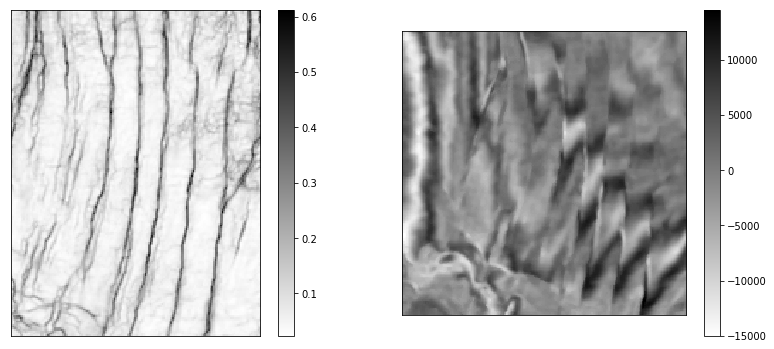

In [8]:
fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(121)
sim = ax.imshow(similarity[:,:,15], cmap='gray_r');
fig.colorbar(sim, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_xaxis()

ax1 = fig.add_subplot(122)
amp = ax1.imshow(seismic[:,:,15], cmap='gray_r');
fig.colorbar(amp, ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.invert_xaxis()

__NB. That does not look right: the amplitude slice is wider than the similarity slice. Based on the filenames, they are supposed to have identical shape! What is going on?__

In [9]:
np.shape(seismic) == np.shape(similarity)

False

In [10]:
print('Amplitude IL/XL shape: ' + str(np.shape(seismic)[0]) + ' / ' +str(np.shape(seismic)[1])) 

Amplitude IL/XL shape: 201 / 201


In [11]:
print('Similarity IL/XL shape: ' + str(np.shape(similarity)[0]) + ' / ' +str(np.shape(similarity)[1])) 

Similarity IL/XL shape: 191 / 146


It looks like in spite of filenames, the amplitude volume has first two dimensions IL/XL=201/201; conversely the similarity, has first two dimensions 191/146!

Let's use `segyio` to dig a bit deeper.

####  Get inline and crossline statistics for the two volumes

In [12]:
with segyio.open(filename, "r") as segyfile:
    # Print inline and crossline ranges
    print('Amplitude Inline range: ' + str(np.amin(segyfile.ilines)) + ' - ' +str(np.amax(segyfile.ilines))) 
    print('Amplitude Crossline range: ' + str(np.amin(segyfile.xlines)) + ' - ' +str(np.amax(segyfile.xlines)))

Amplitude Inline range: 230 - 420
Amplitude Crossline range: 475 - 620


In [13]:
with segyio.open(filename1, "r") as segyfile:
    # Print inline and crossline ranges
    print('Similarity Inline range: ' + str(np.amin(segyfile.ilines)) + ' - ' +str(np.amax(segyfile.ilines))) 
    print('Similarity Crossline range: ' + str(np.amin(segyfile.xlines)) + ' - ' +str(np.amax(segyfile.xlines)))

Similarity Inline range: 230 - 430
Similarity Crossline range: 475 - 675


__NB. That confirmed it: the amplitude volume has 10 extra inlines and 55 extra crosslines__

#### Trim seismic for display purposes

In [14]:
seismic = seismic[0:-10:1, 0:-55:1,:]

In [15]:
assert (np.shape(seismic) == np.shape(similarity))

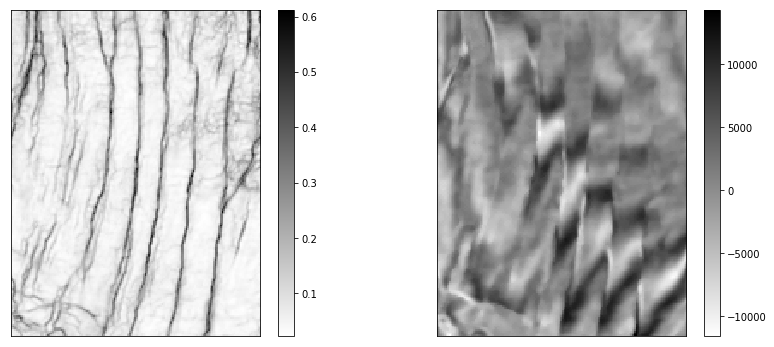

In [16]:
fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(121)
sim = ax.imshow(similarity[:,:,15], cmap='gray_r');
fig.colorbar(sim, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_xaxis()

ax1 = fig.add_subplot(122)
amp = ax1.imshow(seismic[:,:,15], cmap='gray_r');
fig.colorbar(amp, ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.invert_xaxis()

__Perfect!!!__

#### Histogram analysis, threshold definition, threshold to make binary fault image

First I calculate the square of the similtarity to stretch its range. This will help with the following hystogram-based thresholding.

In [17]:
similarity = np.power(similarity,2)

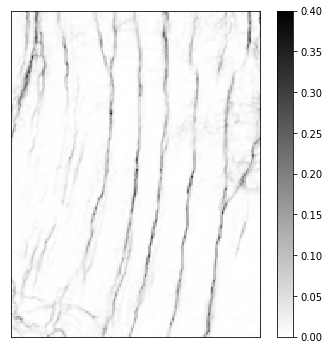

In [18]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(similarity[:,:,15], cmap='gray_r',  vmin =0, vmax=0.4);
plt.gca().invert_xaxis()
plt.colorbar();

The next bit is adapted from this excellent blog post: [Segmentation of 3-D tomography images with Python and scikit-image](http://emmanuelle.github.io/segmentation-of-3-d-tomography-images-with-python-and-scikit-image.html).

In [19]:
hi_sim = exposure.histogram(similarity)

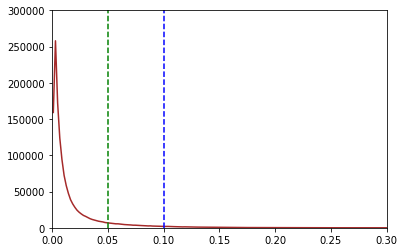

In [20]:
plt.plot(hi_sim[1], hi_sim[0], 'brown')
plt.ylim(0, 300000)
plt.axvline(0.1, color='b', ls='--')
plt.axvline(0.05, color='g', ls='--')
plt.xlim(0,0.3);

That shows a value of (squared) similarity of 0.05 is a good threshold to make the binary fault volume.

In [21]:
binary = np.zeros(similarity.shape, dtype=np.uint8)
binary[similarity > 0.05] = 1

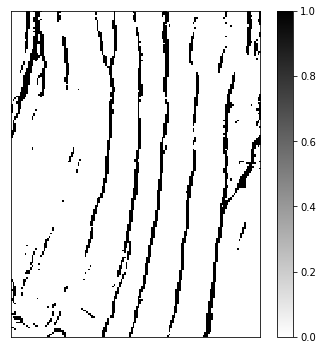

In [22]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(binary[:,:,15], cmap='gray_r');
plt.gca().invert_xaxis()
plt.colorbar();

That looks good. The next bit is to clean-up small minutia in the binary fault image. It's taken from my 2D tutorial [Fun with faults](https://github.com/mycarta/faults/blob/master/fun_with_faults.ipynb). In this case I use 10 pixels after a bit of trial and error.  

In [23]:
label_objects, nb_labels = ndi.label(binary)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 10
mask_sizes[0] = 0
cleaned = mask_sizes[label_objects]*1

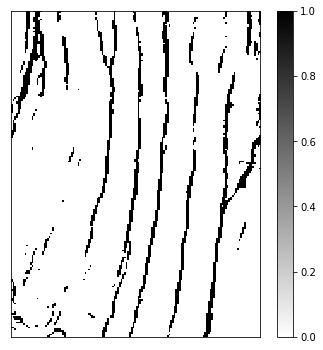

In [24]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(cleaned[:,:,15], cmap='gray_r');
plt.gca().invert_xaxis()
plt.colorbar();

#### For display purposes, make fault mask to display superimposed on amplitude

In [25]:
masked = np.zeros((np.shape(cleaned)))
masked[cleaned == 0] = np.nan

#### Display seismic with superimposed fault mask

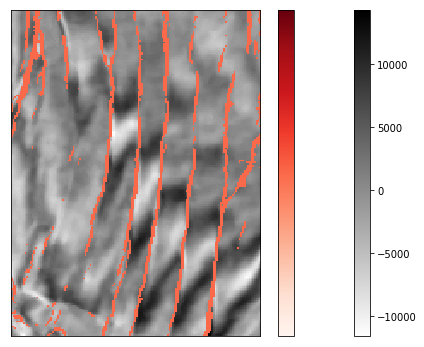

In [26]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(seismic[:,:,15], cmap='gray_r')
plt.colorbar()

plt.imshow(masked[:,:,15], cmap='Reds')
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_ticks([])

#### Export fault volume

To export re-using the input header, I make a copy of the input similarity SEGY file, then write to it the `cleaned` fault array. But first, let's test to ensure inlies are the fast mode. This is important to work with, especially with larger volumes. 

This currently works, but it is unsupported functionality (the developers promise that a [better solution is coming](https://github.com/equinor/segyio/issues/361)).

In [27]:
print('Is inline the fast mode? ' + str(segyfile.fast is segyfile.iline))

Is inline the fast mode? True


Export also requires a double index:
- one zero-based to iterate through the corresponding vertical slices in the `cleaned` fault array
- one based on inline range to iterate through inlines (the fast mode) in the output file

In [28]:
dim = np.shape(similarity)
idx = np.arange(0, dim[0])
print(np.amin(idx), np.amax(idx))

lns = np.arange(np.amin(segyfile.ilines), np.amax(segyfile.ilines)+1)
print(np.amin(lns), np.amax(lns))

0 190
230 430


Finally, ready to export.

In [29]:
cleaned = cleaned.astype('float32')

In [30]:
input_file = '../../data/basic/F3_Similarity_FEF_subvolume_IL230-430_XL475-675_T1600-1800.sgy'
output_file = '../../data/basic/F3_Faults_subvolume_IL230-430_XL475-675_T1600-1800.sgy'

copyfile(input_file, output_file)

with segyio.open(output_file, "r+") as dst:
    for i,j in zip(lns,idx):
        dst.iline[i] = cleaned[j,:,:]

In [31]:
!rm ../../data/basic/F3_Faults_subvolume_IL230-430_XL475-675_T1600-1800.sgy